# Demostration of the Fusion Data Platform (FDP)

In this notebook, we provide a tutorial on how to use the FDP. We will extract DIII-D data using TokSearch and use that data to train and test a ML regression model. In all this steps CMF will be integrated to keep track of all the workflow.

**Task**: To build a regression model, where given the flux surface cross section, the plasma elongation is predicted

## Data extraction

In this section we will use the `dataset_gen.py` script to access the DIII-D database and save a dataset that will be used later for ML modeling.

In the script, the TokSearch package is used to get the flux surface (`psirz`) and elongation (`kappa`) from the DIII-D database with *MdsSignal* and *Pipeline* objects. The script reads the `parameters.json` file where we specify the amount of shots, shot range, dataset path... This example is composed of ~1000 shots with about ~200 time slices per shot.

The scripts selects a certain amount of shots within a shot number range. (Note that many shot numbers were not run or invalid, the script will take that into account) Then it creates a *Pipeline* with all those shots and extracts that data in `Dataset (xarray)` format. We can then put together all the Datasets and write them in a `netCDF` file.

Two different files will be generated: one for the training task and one for testing.

The following command will execute the script using the FDP package (remember to load the right conda environment):

In [1]:
!fdp run python src/dataset_gen.py

/bin/bash: line 1: fdp: command not found


## Optional: Data analysis

We can open the netCDF file and explore what has been stored. We need to load the `xarray` package as it is the native data format for this dataset.

In [2]:
import json
import xarray as xr
import random
import matplotlib.pyplot as plt

In [3]:
#read rparameters from json file
with open('parameters.json') as f:
    params = json.load(f)

ds_kappa_psi=xr.open_dataset(params["train_data_path"])

Let's take a look at the format of the training dataset:

In [4]:
print(ds_kappa_psi)

<xarray.Dataset> Size: 4GB
Dimensions:  (times: 241734, z: 65, r: 65, shot: 1050)
Coordinates:
  * times    (times) float32 967kB 100.0 180.0 200.0 ... 5.266e+06 5.266e+06
  * shot     (shot) int32 4kB 160016 160067 160072 ... 194915 194959 194993
  * z        (z) float32 260B -1.6 -1.55 -1.5 -1.45 -1.4 ... 1.45 1.5 1.55 1.6
  * r        (r) float32 260B 0.84 0.8666 0.8931 0.9197 ... 2.487 2.513 2.54
Data variables:
    psirz    (times, z, r) float32 4GB ...
    kappa    (times) float32 967kB ...


Two quantities (data variables) have been stored: `psirz` (2D flux surface cross section) and `kappa` (plasma elongation). The dataset also contains the coordinates `z` and `r` for 2D flux surface. The `shot` coordinate is just a list of shots used. And the `times` coordinate is just a dummy index variable now (no real time slice).

Note that the data variables are not visible in the above `print` command. This is because xarray/netCDF doesn't load the data until it is used.

### Data plotting

Now let's take a random time index and plot the 2D cross section of flux surfaces

(np.float64(0.8399999737739563),
 np.float64(2.5399999618530273),
 np.float64(-1.600000023841858),
 np.float64(1.600000023841858))

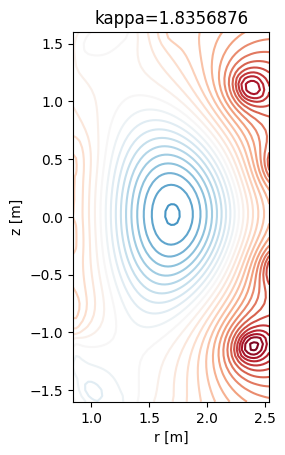

In [5]:
time_slice=random.randint(0,len(ds_kappa_psi['times']))
flux_surf= ds_kappa_psi.isel(times=time_slice)
cplot = flux_surf['psirz'].plot.contour(x=flux_surf['psirz'].dims[1] #so the x axis is R
                                        ,levels=40)
plt.title('kappa='+str(flux_surf['kappa'].values))
plt.axis('scaled')

### Kappa distribution

For every time slice in the dataset a value of plasma elongation (kappa) is given. This quantity will be the target in the following ML modeling. We can first look on how the values are distributed

Text(0.5, 1.0, 'Histogram: plasma elongation in training dataset')

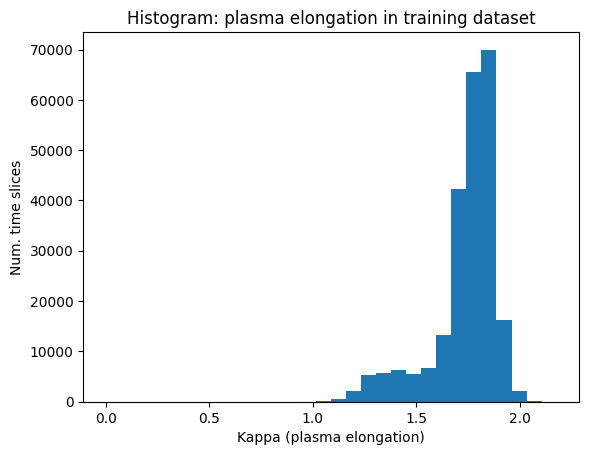

In [6]:
ds_kappa_psi['kappa'].plot.hist(bins=30)
plt.ylabel('Num. time slices')
plt.xlabel('Kappa (plasma elongation)')
plt.title('Histogram: plasma elongation in training dataset')

## Model Training

The task in this tutorial is to train an ML model that predicts plasma elongation given the flux surfaces in a cross section. We are providing an example of a CNN model  in the `Pytorch` framework for this regression task. (This CNN is just a modified LeNet)

The model is in `train.py` and the CNN architecture is in `smallCNN.py`. The hyperparameters can be modified in `parameters.json`. The model will ouput the training and validation losses and will save the model in a `*.pth` file that can be used for the testing step.

The following cell will execute (and train) the model:

In [11]:
!python src/train.py

    
----------------------------------
Starting the training script
----------------------------------
    
Checking for GPU availability...
We are using: cpu
    
Reading the hyperparameters from json file...
Parameters used for training:
  learning_rate: 0.005
  batch_size: 128
  epochs: 5
    
Loading and processing the dataset...
Reading the NETCDF dataset...
<xarray.Dataset> Size: 4GB
Dimensions:  (times: 241734, z: 65, r: 65, shot: 1050)
Coordinates:
  * times    (times) float32 967kB 100.0 180.0 200.0 ... 5.266e+06 5.266e+06
  * shot     (shot) int32 4kB 160016 160067 160072 ... 194915 194959 194993
  * z        (z) float32 260B -1.6 -1.55 -1.5 -1.45 -1.4 ... 1.45 1.5 1.55 1.6
  * r        (r) float32 260B 0.84 0.8666 0.8931 0.9197 ... 2.487 2.513 2.54
Data variables:
    psirz    (times, z, r) float32 4GB ...
    kappa    (times) float32 967kB ...
Normalizing the dataset...
    
Initializing the model, optimizer, and loss function...
    
Starting the training for 5 epochs...


The script will also generate a figure with the loss curves

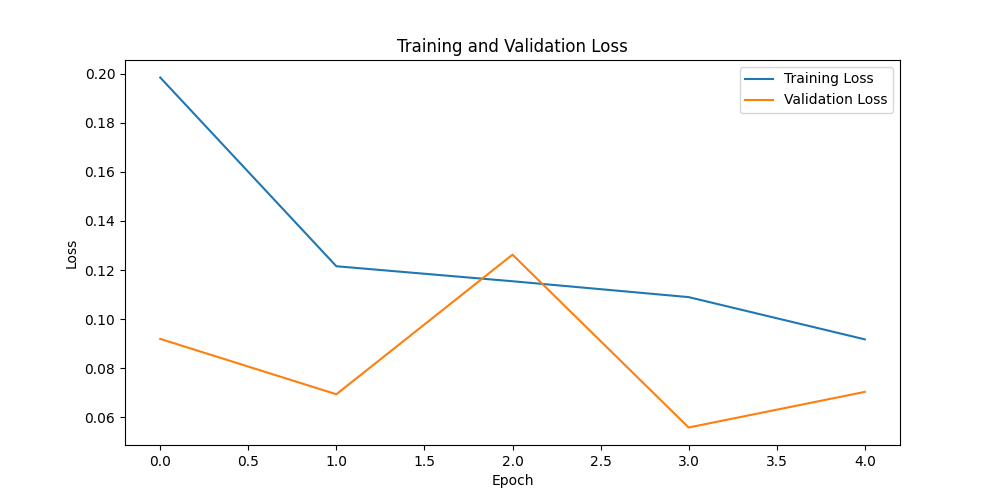

In [12]:
from IPython.display import Image
Image(filename='loss_curves.png')

## Model testing

In this section we will run a script that will test our model (trained in the previous section) using the testing dataset we got when using TokSearch.

The `test.py` script will read the model weights from the `*.pth` file and reconstruct the model. Then calculate the model loss using the testing data. It will also plot a figure with predicted vs real elongation values.

In [13]:
!python src/test.py

    
----------------------------------
Starting the testing script
----------------------------------
    
Reading the hyperparameters from json file...
    
Loading and processing the dataset...
Reading the NETCDF dataset...
<xarray.Dataset> Size: 1GB
Dimensions:  (times: 65451, z: 65, r: 65, shot: 301)
Coordinates:
  * times    (times) float32 262kB 100.0 120.0 140.0 ... 3.706e+05 3.707e+05
  * shot     (shot) int32 1kB 160006 160026 160298 ... 194625 194718 194930
  * z        (z) float32 260B -1.6 -1.55 -1.5 -1.45 -1.4 ... 1.45 1.5 1.55 1.6
  * r        (r) float32 260B 0.84 0.8666 0.8931 0.9197 ... 2.487 2.513 2.54
Data variables:
    psirz    (times, z, r) float32 1GB ...
    kappa    (times) float32 262kB ...
Normalizing the dataset...
 
Initializing the model and loss function...
/home/javierhn/venv_fdp-modeling/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memo

We can also visualize the *accuracy* of the model by plotting that figure generated by the `test.py`.

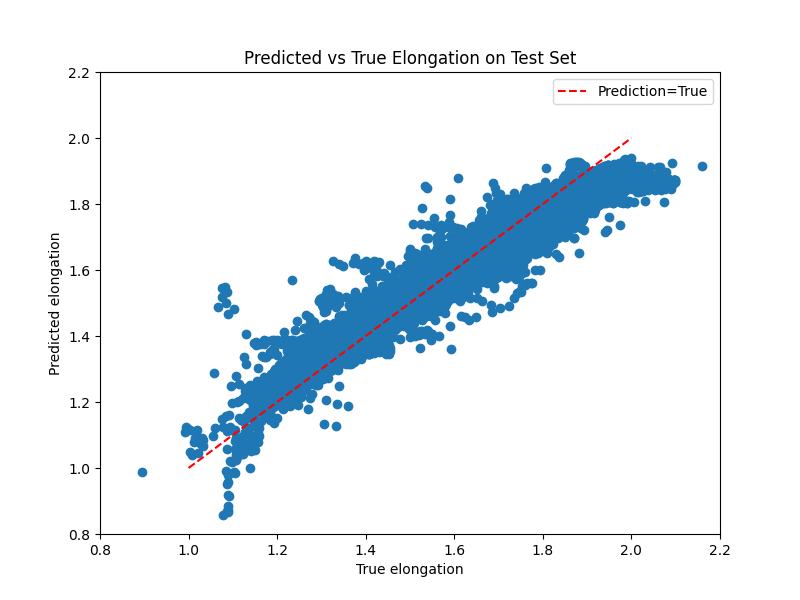

In [14]:

Image(filename='kappa_prediction_test.png')